In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

/Users/peter/opt/anaconda3/envs/mld2/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
tab_count = pd.read_csv("toden/toden_counts.txt", sep="\t")
tab_meta = pd.read_excel("toden/toden_metadata.xlsx")

In [3]:
# Normalization: standard scale

def PreProcessNumerical(df, dfFit, columnNames):
    scaler = StandardScaler()
    scaler.fit(dfFit[columnNames])
    df[columnNames] = scaler.transform(df[columnNames])
    return df

In [5]:
# normalize count data
preTrain = tab_count.copy()
Train = PreProcessNumerical(preTrain, preTrain, preTrain.columns)

In [27]:
# Convert categorical variable ['Apoe.status','apoe_carrier','apoe_dose']
share_feat = ['Apoe.status','apoe_carrier','apoe_dose']
status_dic = {'None': 0, 'E2/E3': 1, 'E2/E4': 2, 'E3/E3': 3, 'E3/E4': 4, 'E4/E4': 5}
carrier_dic = {'None': 0, 'no_apoe4': 0, 'apoe4': 1}
dose_dic = {'apoe4': 1, 'None': 0, 'apoe44': 2, 'no_apoe4': 0}
com_dic = [status_dic, carrier_dic, dose_dic]

meta_feat = tab_meta[share_feat].copy()
for i in range(len(share_feat)):
    meta_feat[share_feat[i]] = [com_dic[i][x] for x in meta_feat[share_feat[i]]]

In [40]:
# df1: standard-scaled count
# df2: standarad-scaled count + share_feat(apoe status, carrier, dose)

df1 = Train.T
df2 = df1.copy()
for i in meta_feat.columns:
    df2[i] = meta_feat[i].values

In [41]:
y = tab_meta['Disease']
ma = {'NCI': 0, 'AD': 1}
for i in range(len(y)):
    y.iloc[i] = ma[y.iloc[i]]

/var/folders/z0/gtt3z07d02n_lrzk3xy2qv0w0000gn/T/ipykernel_12718/2986897895.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.iloc[i] = ma[y.iloc[i]]


In [42]:
train_input=['normalized count', 'normalized count + apoe info']
train_data = [df1, df2]
for i in range(len(train_data)):
    dTrain = train_data[i]
    roc_score = []
    for k,(trainInd, valInd) in enumerate(KFold(shuffle=True,random_state=16).split(dTrain)):
        XTrain = dTrain.iloc[trainInd,]
        yTrain = y.iloc[trainInd,]
        XVal = dTrain.iloc[valInd,]
        yVal = y.iloc[valInd,]
        clf = tree.DecisionTreeClassifier()
        clf = clf.fit(XTrain, list(yTrain))

        pred = clf.predict(XVal)
        roc_score.append(roc_auc_score(list(yVal), clf.predict_proba(XVal)[:,1]))
    print(f"Train: {train_input[i]}, mean val AUC: {sum(roc_score)/len(roc_score)}")


Train: normalized count, mean val AUC: 0.6694128313968563
Train: normalized count + apoe info, mean val AUC: 0.7333790988374884


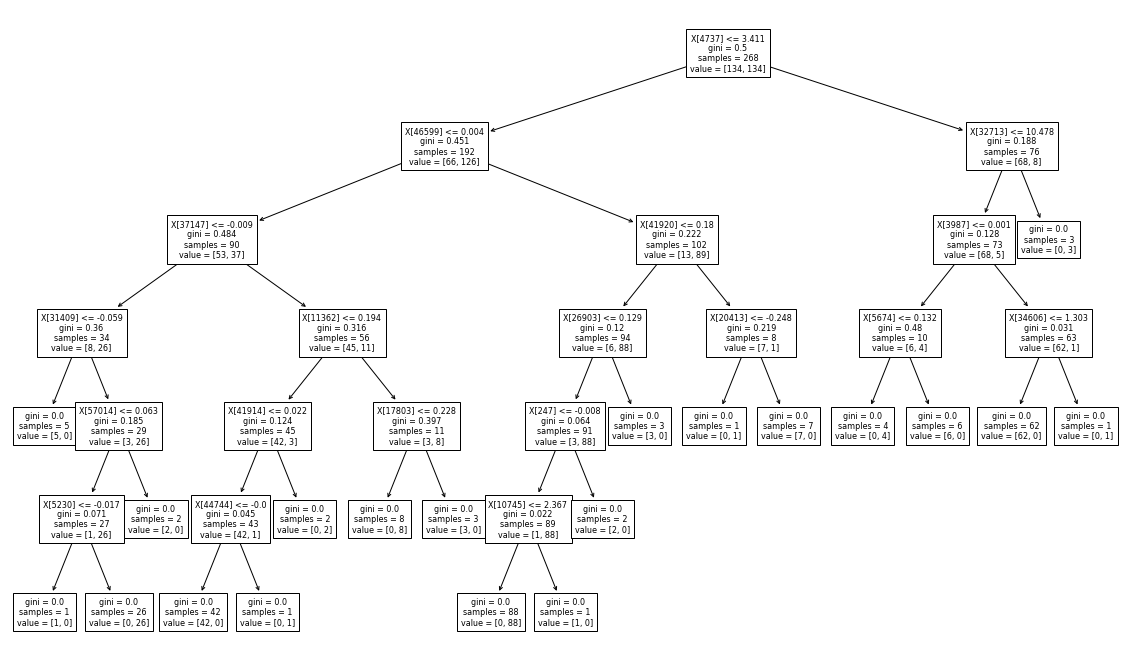

In [43]:
plt.figure(figsize=(20,12))
tree.plot_tree(clf, fontsize=8)
plt.show()

In [44]:
# GaussianNB approach
for i in range(len(train_data)):
    dTrain = train_data[i]
    roc_score = []
    for k,(trainInd, valInd) in enumerate(KFold(shuffle=True,random_state=16).split(dTrain)):
        XTrain = dTrain.iloc[trainInd,]
        yTrain = y.iloc[trainInd,]
        XVal = dTrain.iloc[valInd,]
        yVal = y.iloc[valInd,]
        gnb = GaussianNB()
        gnb.fit(XTrain, yTrain.astype(int))
        pred = gnb.predict(XVal)
        roc_score.append(roc_auc_score(list(yVal), gnb.predict_proba(XVal)[:,1]))
    print(f"Train: {train_input[i]}, mean val AUC: {sum(roc_score)/len(roc_score)}")

Train: normalized count, mean val AUC: 0.6396282619640521
Train: normalized count + apoe info, mean val AUC: 0.6396282619640521


In [46]:
# Random Forest approach
for i in range(len(train_data)):
    dTrain = train_data[i]
    roc_score = []
    for k,(trainInd, valInd) in enumerate(KFold(shuffle=True,random_state=16).split(dTrain)):
        XTrain = dTrain.iloc[trainInd,]
        yTrain = y.iloc[trainInd,]
        XVal = dTrain.iloc[valInd,]
        yVal = y.iloc[valInd,]
        rfc = RandomForestClassifier()
        rfc.fit(XTrain, yTrain.astype(int))
        pred = rfc.predict(XVal)
        roc_score.append(roc_auc_score(list(yVal), rfc.predict_proba(XVal)[:,1]))
    print(f"Train: {train_input[i]}, mean val AUC: {sum(roc_score)/len(roc_score)}")

Train: normalized count, mean val AUC: 0.8392437124788718
Train: normalized count + apoe info, mean val AUC: 0.8333349278033362


In [9]:
# Validation on other two datasets

tab1 = pd.read_csv("silver_seq/silver_seq_counts.txt", sep="\t")
tab2 = pd.read_csv("burgos_dbgap/burgos_dbgap_counts.txt", sep="\t")
